## Drama Genre Predication

In [7]:
# Compilation of all imported packages
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')
import string
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.text.freqdist import FreqDistVisualizer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jose_acosta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1 : Data Expolration
    1. Explore .csv files
        * movie_story_student_file (movie id's and movie plot)
        * movies (movie id's, movie title, and movie genre)
    2. Create datframes from .csv files
        * Display info to get familiar with column headers, data types, and check for NULL values
        * Display first 5 rows of each dataframe
            * movie id is the shared column between datasets
    3. Create a merged dataframe that has movie id, story, and genre columns
        * Found 1,114 records where the genre is listed as 'no genres listed'
        * Change values in DramaGenre column to binary values
            * 1 → Drama
            * 0 → Non-Drama
    4. Visual Exploration
        * Visualization of genre distribution
        * Word cloud of top 100 frequent words
        * Word cloud of top 100 frequest words where genre = drama
        * Frequency of top 50 tokens in dataset where genre = drama
        * Distribution of unique charachters across all reviews 
    5. Clean dataset
        * Used different techniques to reduce the number of tokens
            * PorterStemmer
            * Lemmatizer
        * Used regular expresions to remove unwanted charachters 
        * Distribution of all unique charchters across all reviews
            * Can see which chrachters were removed from regular expressions
   

#### The original datafiles are read into pandas dataframes and gather some preliminary iformation about the type of data and some initial startegies about cleaning the text data.

In [8]:
# creating dataframes for each csv file

movies_student = pd.read_csv('movie_story_student_file.csv', sep= ',', dtype=str) # reading the student movie file and creating dataframe

movie_genres = pd.read_csv('movies.csv', sep= ',', dtype=str) # reading the movies file and creating dataframe

In [9]:
# Displaying file info and first 5 rows from movie_story_student_file.csv

print(movies_student.info(), '\n','\n', movies_student.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  20000 non-null  object
 1   story     20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB
None 
 
   movie_id                                              story
0   131072  A girl who always tends to fall in love with t...
1   196609  Bigfoot has come to the town of Ellwood City, ...
2   131074  At an altitude of 18,000 feet, Alaska\'s Mount...
3   196611  In her first special since 2003, Ellen revisit...
4   196613  Mike and Sulley are back at Monsters Universit...


In [10]:
# Displaying an entire plot
movies_student.loc[2, 'story']

"At an altitude of 18,000 feet, Alaska\\'s Mount St. Elias is the destination for a trio of mountaineers determined to reach the mountain\\'s summit, and to ski back down as well. Mount St. Elias documents their journey as they trek the fine line between bravery and madness."

In [11]:
# Displaying file info and first 5 rows from movies.csv

print(movie_genres.info(), '\n','\n', movie_genres.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23498 entries, 0 to 23497
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  23498 non-null  object
 1   title    23498 non-null  object
 2   genres   23498 non-null  object
dtypes: object(3)
memory usage: 550.9+ KB
None 
 
   movieId                       title                                  genres
0   27509             Carolina (2005)                          Comedy|Romance
1   27618  Sound of Thunder, A (2005)  Action|Adventure|Drama|Sci-Fi|Thriller
2   27788          Jacket, The (2005)           Drama|Mystery|Sci-Fi|Thriller
3   27821     Interpreter, The (2005)                          Drama|Thriller
4   27839        Ring Two, The (2005)           Drama|Horror|Mystery|Thriller


#### Dropping labels from the dataframe containing information that is not required for the analysis

In [12]:
# create main dataset by joining the two dataframes using the movie id columns

# mergred datasets using left merge, dropped unncessary columns
main_dataset = movies_student.merge(movie_genres, how='left', left_on='movie_id', 
                                       right_on='movieId').drop(labels=['movieId', 'title'],axis=1)

# Displaying first 5 row from new dataframe
main_dataset.head()

,movie_id,story,genres
0,131072,A girl who always tends to fall in love with t...,Comedy
1,196609,"Bigfoot has come to the town of Ellwood City, ...",Comedy|Horror
2,131074,"At an altitude of 18,000 feet, Alaska\'s Mount...",Documentary
3,196611,"In her first special since 2003, Ellen revisit...",Comedy
4,196613,Mike and Sulley are back at Monsters Universit...,Animation|Children|Comedy|Fantasy


#### Identified a subset of movies that do not have any information listed for genre. We decided to drop this subset form the dataframe.

In [13]:
# there are 1,114 movies that don't have a genre listed, the values aren't null
(main_dataset.genres == '(no genres listed)').sum()

1114

In [14]:
# displaying 5 records where the genre listed as 'no genres listed'
main_dataset[main_dataset.genres == '(no genres listed)'].head()

,movie_id,story,genres
17,196641,In the months following the terrorist attacks ...,(no genres listed)
35,196675,A 30 years odyssey: the world\'s most intrigui...,(no genres listed)
53,131172,"A man, his dog, a young woman and a filmmaker ...",(no genres listed)
108,196861,"Russian Federation, December 31, 1999. After P...",(no genres listed)
148,196959,I Am JFK Jr. - A Tribute to a Good Man is an h...,(no genres listed)


In [15]:
#Drop 'No genre' rows from the main dataset
main_dataset = main_dataset.drop(main_dataset[main_dataset['genres'] =='(no genres listed)'].index)

#### Convert the Genre label to a buleon Drama Genre label where it is True if one of the listed genres is drama and false is not. Then the original Genre label will be dropped.

In [16]:
# create new column indicaiding if genre is Drama
main_dataset['DramaGenre'] = main_dataset['genres'].str.contains('Drama')

# display first 5 rows of dataframe, now shows new column
main_dataset.head()

,movie_id,story,genres,DramaGenre
0,131072,A girl who always tends to fall in love with t...,Comedy,False
1,196609,"Bigfoot has come to the town of Ellwood City, ...",Comedy|Horror,False
2,131074,"At an altitude of 18,000 feet, Alaska\'s Mount...",Documentary,False
3,196611,"In her first special since 2003, Ellen revisit...",Comedy,False
4,196613,Mike and Sulley are back at Monsters Universit...,Animation|Children|Comedy|Fantasy,False


In [17]:
# changing the values in the DramaGenre column from Boolean to binary
main_dataset['DramaGenre'] = main_dataset['DramaGenre'].map({False:0, True:1})

# dropping unecessary genres column
main_dataset = main_dataset.drop(labels=['genres'], axis=1)

# displaying the first 5 rows from dataframe
main_dataset.head()

,movie_id,story,DramaGenre
0,131072,A girl who always tends to fall in love with t...,0
1,196609,"Bigfoot has come to the town of Ellwood City, ...",0
2,131074,"At an altitude of 18,000 feet, Alaska\'s Mount...",0
3,196611,"In her first special since 2003, Ellen revisit...",0
4,196613,Mike and Sulley are back at Monsters Universit...,0


#### Quick examination of the number of Dramas to Non-dramas that makeup the current dataset.

In [18]:
# displaying the number of drama and non-drama movies in dataset

main_dataset.groupby(by=['DramaGenre']).count()

,movie_id,story
DramaGenre,,
0,10474,10474
1,8412,8412


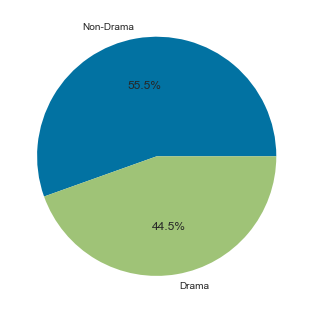

In [19]:
# Visualization of genre distribution

drama_count = main_dataset.groupby(by='DramaGenre').count()

values = drama_count['movie_id']
label = ['Non-Drama', 'Drama']
index = range(len(values))
plt.pie(values, labels= label, autopct='%1.1f%%')
plt.show()

#### To try to understand the dominant word choices in all movie reviews/descriptions, we generated word cloud displays of the Top 100 Words from All Reviews and also a word cloud of the Top 100 Words from All Drama Reviews.

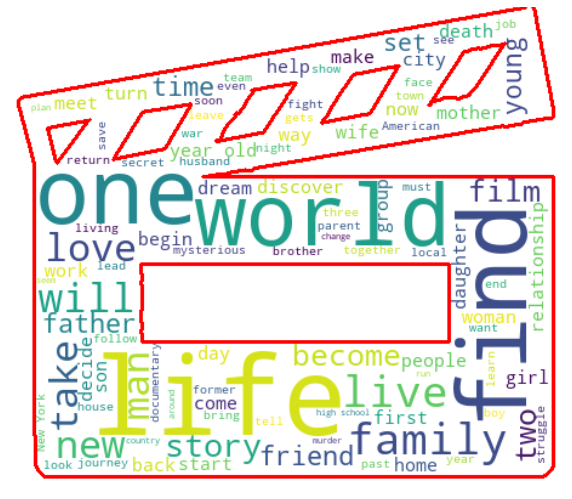

In [20]:
# Word cloud of top 100 words in all reviews

text = " ".join(i for i in main_dataset.story)
#print ("There are {} words in the combination of all review.".format(len(text)))

all_reviews = np.array(Image.open("action.png").convert('L'))
all_reviews.shape

stopwords = set(STOPWORDS)
wordcloud = WordCloud(mask=all_reviews, max_words = 100, stopwords=stopwords, background_color="white",
                      regexp='[A-Za-z]{3,}',min_word_length=3,contour_width=3, 
                      contour_color='red')
                        # contour_width=3, contour_color='red'



wordcloud.generate(text)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

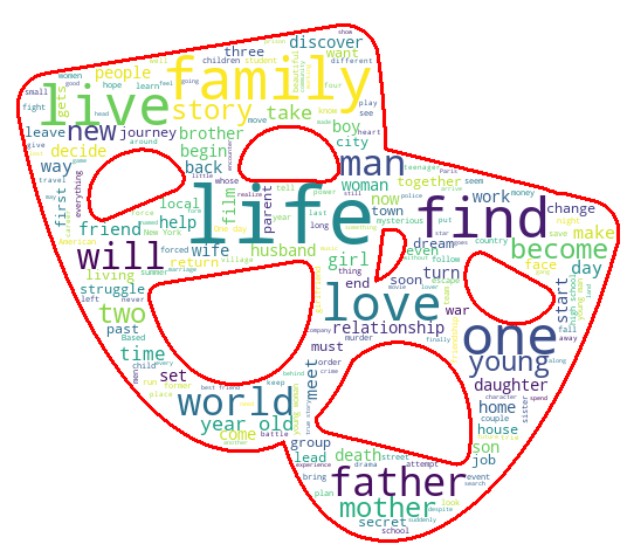

In [21]:
# Word cloud of top 100 words in reviews where genre is 'Drama'

dramadata = main_dataset.loc[main_dataset.DramaGenre==1,['story']]
Dramatext = " ".join(i for i in dramadata.story)

drama = np.array(Image.open("dramaimage.png").convert('L'))
drama.shape

wc = WordCloud(mask=drama,max_font_size=100,stopwords=stopwords, background_color="white",regexp='[A-Za-z]+',contour_width=3, 
               contour_color='red',min_word_length=3)
wc.generate(Dramatext)

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

#### Words within the reviews will be tokenized and examined for frequency of use prior to implementation of any modeling.

In [22]:
def clean_text(text): # Function to remove punctuation
    text ="".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+',text)
    text=[ps.stem(word)for word in tokens if word not in stopwords]
    return text

In [23]:
count_vec = TfidfVectorizer(analyzer=clean_text,max_features=15000)
bag_of_words = count_vec.fit_transform(dramadata['story'])
print(bag_of_words.shape)

(8412, 15000)


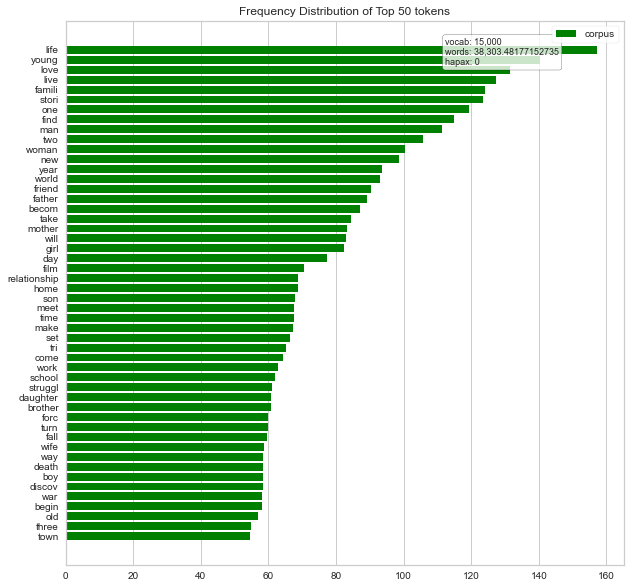

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [24]:
features = count_vec.get_feature_names_out()

# Use yellowbrick package for visualization of top 50 tokens
fig, ax = plt.subplots(figsize=(10,10))
visualizer = FreqDistVisualizer(features=features,color='green',n=50)
visualizer.fit(bag_of_words)
visualizer.poof()

#### The following is a frequency analysis and vizulaization of all individual characters within the reviews.

In [25]:
char_description = pd.Series(main_dataset.story) # creating a Series out of the Story column
char_list = [] # create an empty list
for i in char_description:
    char_list.append(i)  # iterating all reviews into 1 list
    
char_str = str(char_list).lower() # making all charachers in list lowercase

In [26]:
# creating a dictionary of unique charachters from the review and count for each charachter
char_freq = {}
for i in char_str:
    if i in char_freq:
        char_freq[i] += 1
    else:
        char_freq[i] = 1

In [27]:
char_freq # displaying dictionary of charachter and counts

{'[': 9,
 "'": 37164,
 'a': 405303,
 ' ': 1008849,
 'g': 106782,
 'i': 359174,
 'r': 316637,
 'l': 202251,
 'w': 83840,
 'h': 255300,
 'o': 349493,
 'y': 84596,
 's': 327617,
 't': 406145,
 'e': 580970,
 'n': 347600,
 'd': 177369,
 'f': 115078,
 'v': 54958,
 'u': 126142,
 'm': 124644,
 'b': 72957,
 'c': 141609,
 'x': 31435,
 '.': 49337,
 ',': 73516,
 'p': 86421,
 '\\': 67696,
 '2': 7771,
 '8': 7246,
 '0': 9805,
 '9': 11542,
 'k': 39772,
 'j': 11076,
 '!': 581,
 '(': 2263,
 ')': 2270,
 '-': 15412,
 '/': 251,
 'z': 5683,
 '"': 14956,
 '1': 4509,
 '3': 3544,
 '6': 1129,
 '7': 1008,
 '5': 1366,
 'q': 3513,
 ':': 1534,
 '?': 1256,
 ';': 817,
 '&': 179,
 '4': 1939,
 '$': 99,
 '%': 36,
 '#': 22,
 ']': 9,
 '`': 7,
 '*': 7,
 '~': 6,
 '+': 8,
 '|': 3,
 '_': 1,
 '@': 5,
 '=': 3}

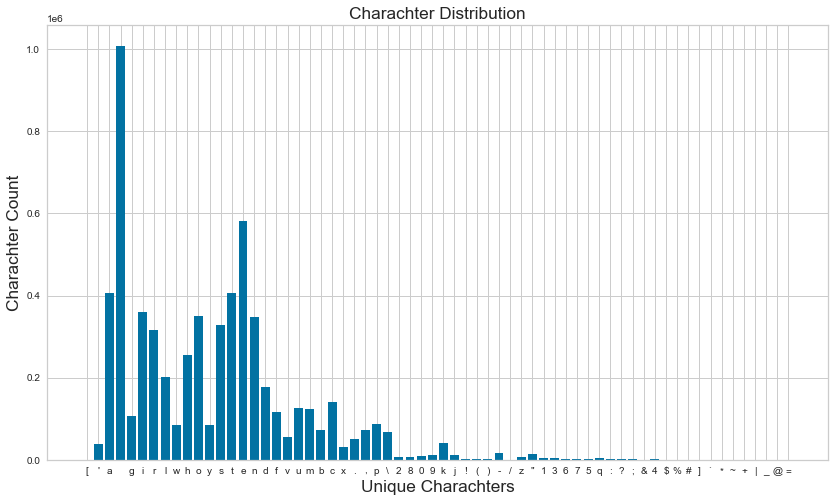

In [28]:
# displaying the distribution of each charachter

import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(14)
f.set_figheight(8)

data = char_freq
names = list(data.keys())
values = list(data.values())


plt.bar(range(len(data)), values, tick_label = names, align='center')
plt.title(label='Charachter Distribution', fontsize='x-large')
plt.ylabel('Charachter Count', fontsize='x-large')
plt.xlabel('Unique Charachters', fontsize='x-large')
plt.show()

In [29]:
#removing punctuations
main_dataset['story'] = main_dataset['story'].str.replace('[^A-Za-z]+',' ')

C:\Users\JOSE_A~1\AppData\Local\Temp/ipykernel_83432/3543931863.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  main_dataset['story'] = main_dataset['story'].str.replace('[^A-Za-z]+',' ')


In [30]:
from nltk.stem import WordNetLemmatizer #39989 words

def lemmat_sentences(row):
    Lemmatizer = WordNetLemmatizer()
    lemmat_tokens = [Lemmatizer.lemmatize(token, pos="v") for token in row.split()]
    return ' '.join(lemmat_tokens)

main_dataset['story_lem'] = main_dataset['story'].apply(lemmat_sentences) 

In [31]:
# instantiate nltk's Porter stemmer 
stemmer = PorterStemmer()

import string
def clean_txt(txt):
    clean_story = []
    words = [char for char in txt if char not in string.punctuation]
    words = ''.join(words)
    tokens = word_tokenize(words)
    clean_story.append(' '.join([stemmer.stem(token) for token in 
                                tokens if re.match('[a-zA-Z]+', token)]))
    return str(clean_story)

In [32]:
main_dataset.iloc[0:5,1].apply(clean_txt)

0    ['a girl who alway tend to fall in love with t...
1    ['bigfoot ha come to the town of ellwood citi ...
2    ['at an altitud of feet alaska s mount st elia...
3    ['in her first special sinc ellen revisit her ...
4    ['mike and sulley are back at monster univers ...
Name: story, dtype: object

In [33]:
main_dataset['story_stem'] = main_dataset.iloc[0:,1].apply(clean_txt)

In [34]:
main_dataset.head()

,movie_id,story,DramaGenre,story_lem,story_stem
0,131072,A girl who always tends to fall in love with t...,0,A girl who always tend to fall in love with th...,['a girl who alway tend to fall in love with t...
1,196609,Bigfoot has come to the town of Ellwood City P...,0,Bigfoot have come to the town of Ellwood City ...,['bigfoot ha come to the town of ellwood citi ...
2,131074,At an altitude of feet Alaska s Mount St Elias...,0,At an altitude of feet Alaska s Mount St Elias...,['at an altitud of feet alaska s mount st elia...
3,196611,In her first special since Ellen revisits her ...,0,In her first special since Ellen revisit her r...,['in her first special sinc ellen revisit her ...
4,196613,Mike and Sulley are back at Monsters Universit...,0,Mike and Sulley be back at Monsters University...,['mike and sulley are back at monster univers ...


In [35]:
main_dataset['story_stem'] = main_dataset['story_stem'].str.replace('[^A-Za-z]+',' ')

C:\Users\JOSE_A~1\AppData\Local\Temp/ipykernel_83432/4216667253.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  main_dataset['story_stem'] = main_dataset['story_stem'].str.replace('[^A-Za-z]+',' ')


In [36]:
main_dataset.head()

,movie_id,story,DramaGenre,story_lem,story_stem
0,131072,A girl who always tends to fall in love with t...,0,A girl who always tend to fall in love with th...,a girl who alway tend to fall in love with th...
1,196609,Bigfoot has come to the town of Ellwood City P...,0,Bigfoot have come to the town of Ellwood City ...,bigfoot ha come to the town of ellwood citi p...
2,131074,At an altitude of feet Alaska s Mount St Elias...,0,At an altitude of feet Alaska s Mount St Elias...,at an altitud of feet alaska s mount st elia ...
3,196611,In her first special since Ellen revisits her ...,0,In her first special since Ellen revisit her r...,in her first special sinc ellen revisit her r...
4,196613,Mike and Sulley are back at Monsters Universit...,0,Mike and Sulley be back at Monsters University...,mike and sulley are back at monster univers f...


# Step 2: Create Variables
    * X → independent variables
    * y → dependent variables

In [37]:
# independent variable using stemmer
X_stem = main_dataset.story_stem

# independent variable using Lemmatizer
X_lem = main_dataset.story_lem

# dependent variable
y = main_dataset.DramaGenre

# Step 3: Supervised Learning Techniques

### Bag of Words
    * Using bag of words to create sparse matrix of tokens
    * There are a total of 32,271 tokens

In [38]:
# Instantiate CountVecotorizer, making all tokens lowercase, and removing stopwords
vect_BoW = CountVectorizer(lowercase=True, stop_words='english')

# fit model, this creates the vocabulary
vect_BoW.fit(X_stem)

# assigning sparse matrix to variable
bag_of_words = vect_BoW.transform(X_stem)
bag_of_words

<18886x32271 sparse matrix of type '<class 'numpy.int64'>'
	with 516011 stored elements in Compressed Sparse Row format>

In [39]:
len(vect_BoW.get_feature_names_out())

32271

#### Bag of Words - Multinomial Naive Bayes 

In [40]:
X_NB = bag_of_words

# Instantiate Multinomial Naive Bayes
model = MultinomialNB()

# Split dataset to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_NB, y, test_size = 0.3, stratify = y, 
                                                    random_state = 0)

# Fit model
model.fit(X_train, y_train)


y_test_hat_NB = model.predict(X_test)
y_train_hat_NB = model.predict(X_train)

# print in and out-of-sample accuracy
print('In Sample Accuracy: ', round(accuracy_score(y_train, y_train_hat_NB) * 100,2))
print('Out-of-Sample Accuracy: ', round(accuracy_score(y_test, y_test_hat_NB) * 100,2),'\n')

# print classification performace measures
print(classification_report(y_test, y_test_hat_NB))

In Sample Accuracy:  84.61
Out-of-Sample Accuracy:  69.08 

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      3142
           1       0.65      0.66      0.66      2524

    accuracy                           0.69      5666
   macro avg       0.69      0.69      0.69      5666
weighted avg       0.69      0.69      0.69      5666



In [41]:
x = classification_report(y_test, y_test_hat_NB).split()
results = {}
results['Bag of Words - Multinomial Naive Bayes'] = [round(accuracy_score(y_train, y_train_hat_NB) * 100,2),
                                                     round(accuracy_score(y_test, y_test_hat_NB) * 100,2),
                                                     float(x[5]),
                                                     float(x[6]),
                                                     float(x[7]),
                                                     float(x[10]),
                                                     float(x[11]),
                                                     float(x[12]),
                                                     float(x[15])]

### TF - IDF
    * Logistic Regression

In [42]:

count_vec = TfidfVectorizer(analyzer=clean_text,max_features=15000,sublinear_tf=True)
bag_of_words_tfidf = count_vec.fit_transform(main_dataset['story_stem'])

print(bag_of_words_tfidf.shape)


model_lgr = LogisticRegression(solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(bag_of_words_tfidf, y, test_size=0.3, 
                                                    random_state=0,stratify=y)
model_lgr.fit(X_train, y_train)

y_test_hat = model_lgr.predict(X_test)
y_train_hat = model_lgr.predict(X_train)

print('In-Sample Accuracy: ',round(accuracy_score(y_train,y_train_hat) * 100,2))
print('Out-of-Sample Accuracy: ',round(accuracy_score(y_test,y_test_hat) * 100,2))
print()
# print classification performace measures
print(classification_report(y_test, y_test_hat))

(18886, 15000)
In-Sample Accuracy:  82.35
Out-of-Sample Accuracy:  69.75

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3142
           1       0.68      0.61      0.64      2524

    accuracy                           0.70      5666
   macro avg       0.69      0.69      0.69      5666
weighted avg       0.70      0.70      0.70      5666



In [38]:
x = classification_report(y_test, y_test_hat).split()
results['TF-IDF - Logistic Regression'] = [round(accuracy_score(y_train, y_train_hat) * 100,2),
                                           round(accuracy_score(y_test, y_test_hat) * 100,2),
                                           float(x[5]),
                                           float(x[6]),
                                           float(x[7]),
                                           float(x[10]),
                                           float(x[11]),
                                           float(x[12]),
                                           float(x[15])]

### TF - IDF and Truncated SVD - NN

In [38]:
story= main_dataset.story

vect = TfidfVectorizer(ngram_range=(1,3), stop_words="english").fit(story) 
X1 = vect.transform(story)

from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components = 200)
X_tsvd = tsvd.fit_transform(X1)

In [39]:
from sklearn.neural_network import MLPClassifier
model2 = MLPClassifier(solver='lbfgs',random_state=0, max_iter=5000, 
                      hidden_layer_sizes=[10,10]) 

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tsvd, y, 
                                                    test_size=0.3, 
                                                    random_state=0,
                                                    stratify = y)
model2.fit(X_train2,y_train2)
y_test_hat3 = model2.predict(X_test2)


print("Accuracy with Neural Network: {}".format(round(accuracy_score(y_test2,y_test_hat3) * 100,2)))
print()
print('Classification Report for Neural Network')
print()
print(classification_report(y_test2,y_test_hat3))

Accuracy with Neural Network: 68.6

Classification Report for Neural Network

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      3142
           1       0.66      0.60      0.63      2524

    accuracy                           0.69      5666
   macro avg       0.68      0.68      0.68      5666
weighted avg       0.68      0.69      0.68      5666



In [40]:
x = classification_report(y_test, y_test_hat3).split()
results['TF-IDF - Neural Network'] = ['N/A','N/A',
                                       float(x[5]),
                                       float(x[6]),
                                       float(x[7]),
                                       float(x[10]),
                                       float(x[11]),
                                       float(x[12]),
                                       float(x[15])]

### Truncated SVD
    * Logistic Regression

In [41]:
# itterating through range of n_components to get optimal number

vect = CountVectorizer(stop_words="english",max_features = 20000)
vect.fit(main_dataset.story_lem)
X_lem = vect.transform(main_dataset.story_lem)


from sklearn.decomposition import TruncatedSVD

for i in range(500,100,100):
    tsvd = TruncatedSVD(n_components = i)
    X_tsvd = tsvd.fit_transform(X_lem)
    model = LogisticRegression(C=1000,solver='liblinear')
    X_train, X_test, y_train, y_test = train_test_split(X_tsvd, y, 
                                                        test_size=0.3, 
                                                        random_state=0,
                                                        stratify=y)
    model.fit(X_train, y_train)
    y_test_hat = model.predict(X_test)
    print('For {} features, accuracy is {}'.format(i,round(accuracy_score(y_test,y_test_hat) * 100,2)))
    print('****')

In [42]:
from sklearn.decomposition import TruncatedSVD

vect = CountVectorizer(stop_words="english",max_features = 20000)
vect.fit(main_dataset.story_lem)
X_lem = vect.transform(main_dataset.story_lem)


tsvd = TruncatedSVD(n_components = 700)
X_tsvd = tsvd.fit_transform(X_lem)

SVD_model = LogisticRegression(C=1000,solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(X_tsvd, y, 
                                                    test_size=0.3, 
                                                    random_state=0,
                                                   stratify=y)

SVD_model.fit(X_train, y_train)

y_test_hat = SVD_model.predict(X_test)
y_train_hat = SVD_model.predict(X_train)

print('In sample accruacy: {}'.format(round(accuracy_score(y_train,y_train_hat)*100,2)))
print('Out of sample accuracy: {}'.format(round(accuracy_score(y_test,y_test_hat) * 100,2)))

print()
print(classification_report(y_test, y_test_hat))

In sample accruacy: 73.18
Out of sample accuracy: 68.11

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      3142
           1       0.65      0.62      0.64      2524

    accuracy                           0.68      5666
   macro avg       0.68      0.68      0.68      5666
weighted avg       0.68      0.68      0.68      5666



In [43]:
x = classification_report(y_test, y_test_hat).split()
results['TF-IDF - Truncated SVD'] = [round(accuracy_score(y_train, y_train_hat) * 100,2),
                                     round(accuracy_score(y_test, y_test_hat) * 100,2),
                                     float(x[5]),
                                     float(x[6]),
                                     float(x[7]),
                                     float(x[10]),
                                     float(x[11]),
                                     float(x[12]),
                                     float(x[15])]

### WORD EMBEDDING
    * Random Forest
    * Neural Network

In [44]:
descriptions = main_dataset.loc[:,'story']

target = main_dataset.loc[:,'DramaGenre']

#Word embedding
embeddings_index = dict()
# It is a global vector file used for word representation
# It is opening the file and putting it line by line in the dictionary #the similar words are located near each other
f = open('glove.6B.50d.txt',encoding="utf8")
# Line by line it reads the data and puts that in one dictionary
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
# After this step we will get vectors for each word

In [45]:
# Tokenizing sentence that we have i.e separating each word in a sentence
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# To keep the track of progress
from tqdm import tqdm
embeddings = []
for review in tqdm(descriptions):

    # One sentence embedding and initalize it with zero; word_count = 0 and we are putting one sentence embbedding
    # and initialize it with zero ; 50 dimensional all zeroes
    base_embedding = np.zeros((50,))
    word_count = 0
    # We are going token by token and find embedding for each token; capturing that token and adding that to the 
    # sentence embedding
    for token in word_tokenize(review):
        # Convert everything to lower case as the words on Glove file is in lower case
        token = token.lower()
        # Try and except continue, there are some words in the movie description which we may not be able to 
        # capture with embedding
        if token in stopwords.words('english'):
            continue
        try:
            base_embedding += embeddings_index[token]
            word_count +=1
        except:
            continue
    base_embedding = base_embedding/word_count
    # Appends vector to the embedding
    embeddings.append(base_embedding)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ianbi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ianbi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████████| 18886/18886 [04:50<00:00, 64.90it/s]


In [46]:
X = np.array(embeddings)
X.shape

(18886, 50)

In [47]:
y= main_dataset.DramaGenre
y=y.astype("int64")

#### Word Embedding - Neural Netowrk

In [48]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs',random_state=0, max_iter=5000, 
                      hidden_layer_sizes=[5,5]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0,
                                                   stratify = y)

model.fit(X_train,y_train)
y_test_hat = model.predict(X_test)

print("Accuracy with Neural Network: {}".format(round(accuracy_score(y_test,y_test_hat) * 100,2)))
print()
print('Classification Report for Neural Network')
print()
print(classification_report(y_test,y_test_hat))

Accuracy with Neural Network: 66.89

Classification Report for Neural Network

              precision    recall  f1-score   support

           0       0.69      0.72      0.71      3142
           1       0.63      0.60      0.62      2524

    accuracy                           0.67      5666
   macro avg       0.66      0.66      0.66      5666
weighted avg       0.67      0.67      0.67      5666



In [49]:
x = classification_report(y_test, y_test_hat).split()
results['Word Embedding - Neural Network'] = ['N/A','N/A',
                                               float(x[5]),
                                               float(x[6]),
                                               float(x[7]),
                                               float(x[10]),
                                               float(x[11]),
                                               float(x[12]),
                                               float(x[15])]

In [50]:
model1 = RandomForestClassifier(n_estimators=200, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, 
                                                    random_state=0,
                                                   stratify = y)

model1.fit(X_train,y_train)

y_test_hat1 = model1.predict(X_test)

print("Accuracy with Random Forest: {}".format(round(accuracy_score(y_test,y_test_hat1) * 100,2)))
print()
print('Classification Report for Random Forest Classifier')
print()
print(classification_report(y_test,y_test_hat1))

Accuracy with Random Forest: 66.11

Classification Report for Random Forest Classifier

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      3142
           1       0.64      0.53      0.58      2524

    accuracy                           0.66      5666
   macro avg       0.66      0.65      0.65      5666
weighted avg       0.66      0.66      0.66      5666



In [61]:
x = classification_report(y_test, y_test_hat1).split()
results['Word Embedding - Random Forest'] = ['N/A','N/A',
                                              float(x[5]),
                                              float(x[6]),
                                              float(x[7]),
                                              float(x[10]),
                                              float(x[11]),
                                              float(x[12]),
                                              float(x[15])]

In [63]:
model_results = pd.DataFrame.from_dict(results, orient='index',
                                       columns = ['In-Sample Accuracy',
                                       'Out-Sample Accuracy',
                                       'Not Drama Precision',
                                       'Not Drama Recall',
                                       'Not Drama F1',
                                       'Drama Precision',
                                       'Drama Recall',
                                       'Drama F1',
                                       'Accuracy'])

In [64]:
model_results

,In-Sample Accuracy,Out-Sample Accuracy,Not Drama Precision,Not Drama Recall,Not Drama F1,Drama Precision,Drama Recall,Drama F1,Accuracy
Bag of Words - Multinomial Naive Bayes,84.61,69.08,0.72,0.71,0.72,0.65,0.66,0.66,0.69
TF-IDF - Logistic Regression,82.35,69.75,0.71,0.77,0.74,0.68,0.61,0.64,0.70
TF-IDF - Neural Network,N/A,N/A,0.70,0.76,0.73,0.66,0.60,0.63,0.69
TF-IDF - Truncated SVD,73.18,68.11,0.71,0.73,0.72,0.65,0.62,0.64,0.68
Word Embedding - Neural Network,N/A,N/A,0.69,0.72,0.71,0.63,0.60,0.62,0.67
Word Embedding - Random Forest,N/A,N/A,0.67,0.76,0.71,0.64,0.53,0.58,0.66


### Evaluation_dataset file 

In [43]:
eval_data = pd.read_csv('movie_story_evaluation_file.csv', sep= ',', dtype=str)
eval_data.head()

,movie_id,story
0,122349,Growing up in the Mission district of San Fran...
1,122351,A soldier returns home from the Iraq war only ...
2,122361,Marco the Monkey works as a beach officer. But...
3,187901,"When an honest cop, Vijay Kumar\'s family is r..."
4,187903,"Kathiresan aka Kaththi, a criminal, escapes fr..."


In [44]:
evaluation_dataset = pd.merge(eval_data,movie_genres,left_on='movie_id',right_on='movieId').drop(columns=['movieId','title'],axis=1)
evaluation_dataset.head()

,movie_id,story,genres
0,122349,Growing up in the Mission district of San Fran...,Drama
1,122351,A soldier returns home from the Iraq war only ...,Horror|Thriller
2,122361,Marco the Monkey works as a beach officer. But...,Animation|Children|Comedy
3,187901,"When an honest cop, Vijay Kumar\'s family is r...",Action|Romance
4,187903,"Kathiresan aka Kaththi, a criminal, escapes fr...",Action|Drama|Romance


In [45]:
evaluation_dataset['DramaGenre'] = evaluation_dataset['genres'].str.contains('Drama')
evaluation_dataset['DramaGenre'] = evaluation_dataset.DramaGenre.map({False:0,True:1})
evaluation_dataset = evaluation_dataset.drop(['genres'],axis=1)
evaluation_dataset['story_stem'] = evaluation_dataset.iloc[0:,1].apply(clean_txt)
evaluation_dataset['story_stem'] = evaluation_dataset['story_stem'].str.replace('[^A-Za-z]+',' ')
evaluation_dataset.head()

C:\Users\JOSE_A~1\AppData\Local\Temp/ipykernel_83432/1177543106.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  evaluation_dataset['story_stem'] = evaluation_dataset['story_stem'].str.replace('[^A-Za-z]+',' ')


,movie_id,story,DramaGenre,story_stem
0,122349,Growing up in the Mission district of San Fran...,1,grow up in the mission district of san franci...
1,122351,A soldier returns home from the Iraq war only ...,0,a soldier return home from the iraq war onli ...
2,122361,Marco the Monkey works as a beach officer. But...,0,marco the monkey work as a beach offic but he...
3,187901,"When an honest cop, Vijay Kumar\'s family is r...",0,when an honest cop vijay kumar famili is ruth...
4,187903,"Kathiresan aka Kaththi, a criminal, escapes fr...",1,kathiresan aka kaththi a crimin escap from th...


In [46]:
evaluation_dataset['DramaGenre'].value_counts()

0    2075
1    1423
Name: DramaGenre, dtype: int64

### Top 30 tokens for evaluations excel

(3498, 14908)


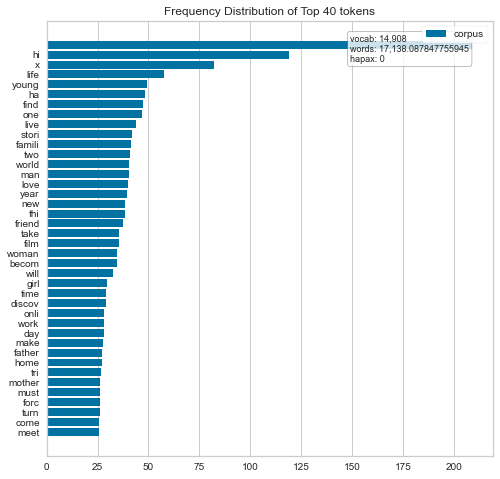

<AxesSubplot:title={'center':'Frequency Distribution of Top 40 tokens'}>

In [47]:
count_vec_eval = TfidfVectorizer(analyzer=clean_text,max_features=15000,sublinear_tf=True)
dataeval_bag_of_words = count_vec_eval.fit_transform(evaluation_dataset['story_stem'])
print(dataeval_bag_of_words.shape)

feature_eval = count_vec_eval.get_feature_names_out()

# Use yellowbrick package for visualization of top 40 tokens
fig, ax = plt.subplots(figsize=(8,8))
visualizer = FreqDistVisualizer(features=feature_eval, n=40)
visualizer.fit(dataeval_bag_of_words)
visualizer.poof()

In [48]:
Drama_y=evaluation_dataset.DramaGenre
Drama_y

0       1
1       0
2       0
3       0
4       1
       ..
3493    1
3494    0
3495    0
3496    0
3497    1
Name: DramaGenre, Length: 3498, dtype: int64

### Best Model of Logistic Regression

In [49]:
##count_vec = TfidfVectorizer(analyzer=clean_text,max_features=14908,sublinear_tf=True)
##bag_of_words_tfidf = count_vec.fit_transform(main_dataset['story_stem'])

In [50]:
##bag_of_words_tfidf

In [51]:


# running TF-IDF vectorizer 
count_vec = TfidfVectorizer(analyzer=clean_text,max_features=14908,sublinear_tf=True)
bag_of_words_tfidf = count_vec.fit_transform(main_dataset['story_stem'])

# instantiate model
model = LogisticRegression(solver='liblinear')

# fitting the entire X and y dataset
model.fit(bag_of_words_tfidf, y)

# predict 
y_eval_hat = model.predict(dataeval_bag_of_words)

y_eval_hat

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [52]:
bag_of_words_tfidf

<18886x14908 sparse matrix of type '<class 'numpy.float64'>'
	with 565718 stored elements in Compressed Sparse Row format>

In [53]:
print("Accuracy for Logistic: {}".format(round(accuracy_score(Drama_y,y_eval_hat) * 100,2)))
print('-------------------------------------------------------------------------')
print(classification_report(Drama_y,y_eval_hat))

Accuracy for Logistic: 57.18
-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.89      0.71      2075
           1       0.41      0.11      0.18      1423

    accuracy                           0.57      3498
   macro avg       0.50      0.50      0.44      3498
weighted avg       0.52      0.57      0.49      3498

